In [17]:
import numpy as np
from pyspark.mllib.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext, Row

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%pylab inline




Populating the interactive namespace from numpy and matplotlib


In [19]:
feature_names = ['sepal length (cm)',
                'sepal width (cm)',
                'petal length (cm)',
                'petal width (cm)']
target_names = ['setosa', 'versicolor', 'virginica']
target_indices = sc.parallelize(target_names).zipWithIndex()
print target_indices.take(3)
names_df = target_indices.map(lambda row: Row(type=row[0], index=row[1])).toDF()

[('setosa', 0), ('versicolor', 1), ('virginica', 2)]


In [20]:
random_points = sc.textFile("../data/iris.csv")
random_points.cache()
random_points.takeSample(True, 5)

[u'5.7,2.8,4.5,1.3,versicolor',
 u'6.7,3.0,5.2,2.3,virginica',
 u'4.8,3.4,1.6,0.2,setosa',
 u'5.0,3.5,1.3,0.3,setosa',
 u'6.9,3.1,5.1,2.3,virginica']

In [21]:
data_df = random_points.map(lambda row: row.split(",")).map(lambda row: Row(
        sepal_length=float(row[0]),
        sepal_width=float(row[1]),
        petal_length=float(row[2]),
        petal_width=float(row[3]),
        type=row[4])).toDF()
data = data_df.map(lambda row: np.array([float(row[0]), float(row[1]), float(row[2]), float(row[3])]))
data_df.take(5)

[Row(petal_length=1.4, petal_width=0.2, sepal_length=5.1, sepal_width=3.5, type=u'setosa'),
 Row(petal_length=1.4, petal_width=0.2, sepal_length=4.9, sepal_width=3.0, type=u'setosa'),
 Row(petal_length=1.3, petal_width=0.2, sepal_length=4.7, sepal_width=3.2, type=u'setosa'),
 Row(petal_length=1.5, petal_width=0.2, sepal_length=4.6, sepal_width=3.1, type=u'setosa'),
 Row(petal_length=1.4, petal_width=0.2, sepal_length=5.0, sepal_width=3.6, type=u'setosa')]

In [22]:
centers = 3
model = KMeans.train(data, centers)

In [23]:
for i , center in enumerate(model.centers):
    print i, center

0 [ 1.464  0.244  5.006  3.418]
1 [ 5.74210526  2.07105263  6.85        3.07368421]
2 [ 4.39354839  1.43387097  5.9016129   2.7483871 ]


In [24]:
m2 = sc.broadcast(model)
labels = data.map(lambda row: m2.value.predict(row)).collect()
X = data_df.select('petal_width').collect()
Y = data_df.select('sepal_length').collect()
Z = data_df.select('petal_length').collect()

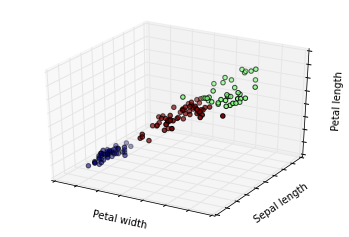

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c=labels)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

In [54]:
ind = data_df.select('type').join(names_df, data_df.type == names_df.type).select('index').collect()
ind[:5]

[Row(index=2), Row(index=2), Row(index=2), Row(index=2), Row(index=2)]

Row(AVG(petal_length#31)=1.464, AVG(petal_width#32)=0.2439999999999999, AVG(sepal_length#33)=5.005999999999999) setosa
Row(AVG(petal_length#31)=4.26, AVG(petal_width#32)=1.3260000000000003, AVG(sepal_length#33)=5.936) versicolor
Row(AVG(petal_length#31)=5.552, AVG(petal_width#32)=2.026, AVG(sepal_length#33)=6.587999999999998) virginica


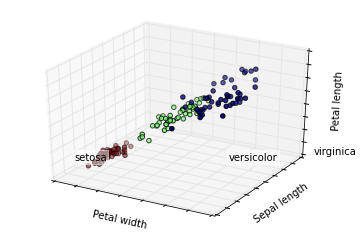

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_df.select('petal_width').collect(),
           data_df.select('sepal_length').collect(),
           data_df.select('petal_length').collect(), c=ind)
for name, label in target_indices.collect():
    X_mean = data_df.filter(data_df.type == name).agg(
        {'petal_width': 'avg', 'sepal_length': 'avg', 'petal_length': 'avg'}).collect()[0]
    print X_mean, name
    ax.text3D(X_mean[0], X_mean[1] + 1.5, X_mean[2], name,
             horizontalalignment='center',
             bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')